# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, rand, split
from pyspark.sql.types import IntegerType, BooleanType, StringType, ArrayType, DoubleType
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
dataset_path = "data/medium_sparkify_event_data.json"

In [4]:
df = spark.read.json(dataset_path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.select("*").show(1)

+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|         song|status|           ts|           userAgent|userId|
+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+
|Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+---------

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Submit Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Let's define the churn function that will find set 1 when row means churn and 0 otherwise. To find a churn we'll use the `page` when `Submit Downgrade` and `Cancellation Confirmation` event happened. Let's treat churn and downgrade users separetely, as each of them can have significant differences in behavior.

In [7]:
def isChurn(page):
    if page == "Submit Downgrade" or page == "Cancellation Confirmation":
        return True
    return False

In [8]:
def churn(value):
    if value == "Cancellation Confirmation":
        return 2
    if value == "Submit Downgrade":
        return 1
    return 0

Now let's apply this function our dataframe.

In [9]:
setChurn = udf(churn, IntegerType())
df = df.withColumn("churn", setChurn(df.page))

So now let's take churned and downgraded users id's and let's put them to separate collection. First let's collect id of users that left our service by reasons.

In [10]:
churned_ids = df.filter(df.churn == 2).select("userId").dropDuplicates().collect()
churned_ids = [i.userId for i in churned_ids]

downgraded_ids = df.filter(df.churn == 1).select("userId").dropDuplicates().collect()
downgraded_ids = [i.userId for i in downgraded_ids]

Now let's define two functions that will find users that are churned and not churned.

In [11]:
isInChurn = udf(lambda x: x in (churned_ids), BooleanType())
isInDowngraded = udf(lambda x: x in (downgraded_ids), BooleanType())
notInChurn = udf(lambda x: x not in (churned_ids+downgraded_ids), BooleanType())

### Do we have null values across the dataset?

Now as we have simple churn defined, let's take a look more on how the dataset looks llike. First let's see which column has a null value and how much of these values are there

In [12]:
for column in df.columns:
    print("Column {} contains {} null values".format(column, df.where(col(column).isNull()).count()))

Column artist contains 110828 null values
Column auth contains 0 null values
Column firstName contains 15700 null values
Column gender contains 15700 null values
Column itemInSession contains 0 null values
Column lastName contains 15700 null values
Column length contains 110828 null values
Column level contains 0 null values
Column location contains 15700 null values
Column method contains 0 null values
Column page contains 0 null values
Column registration contains 15700 null values
Column sessionId contains 0 null values
Column song contains 110828 null values
Column status contains 0 null values
Column ts contains 0 null values
Column userAgent contains 15700 null values
Column userId contains 0 null values
Column churn contains 0 null values


So it looks like some of the values are nulls. We can see that number of different values are the same across all columns, let's see what can be cause of this situation.

Let's check if the same number null values have correclation with columns.

In [13]:
df.select("page").where((col("artist").isNull()) | (col("length").isNull()) | (col("song").isNull())).dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

So these pages are not connected with playing a song at all, that's then understandable why the 'artist', 'length' and 'song' columns contain null values - they are not existing is such situation.

Now let's see the columns for first and last name, gender and userAgent.

In [14]:
df.select("page").where((col("firstName").isNull()) | (col("gender").isNull()) | (col("lastName").isNull()) | (col("location").isNull()) | (col("registration").isNull()) | (col("userAgent").isNull())).dropDuplicates().collect()

[Row(page='Home'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Help'),
 Row(page='Error')]

So the reason why these columns contains null values is that, the events are connected to the operations done by the users out of the logged session.

### How many users churned from the service?

In [15]:
print("Number of churned users: {}".format(df.filter(isInChurn(df.userId)).select("userId").dropDuplicates().count()))
print("Number of downgraded users: {}".format(df.filter(isInDowngraded(df.userId)).select("userId").dropDuplicates().count()))
print("Number of staying users: {}".format(df.filter(notInChurn(df.userId)).select("userId").dropDuplicates().count()))

Number of churned users: 99
Number of downgraded users: 97
Number of staying users: 274


So it looks like for the sparkify mini event data less users had events `Submit Downgrade` or `Cancellation Confirmation` from users which didn't take that options, however there can be users that returned to the service after leaving it e.g. downgraded from premium and still were using it for free - this situation allow us only to get money from advertisements during the free sessions.

### How churn rate distribute over genders?

Let's see which users of which gender are more likely to churn. First let's get the dataframe of churn users.

In [16]:
users_ch=df.filter(isInChurn(df.userId)).select("userId", "gender", "churn").dropDuplicates(["userId"]).toPandas()
users_ch.head()

,userId,gender,churn
0,100010,F,0
1,200002,M,0
2,296,F,0
3,124,F,0
4,51,M,0


But what is it? The `churn` column contains 0? Indeed it's because we filter out the users with Id's that performed downgrade of the account and due to `dropDuplicates()` the information about churn for downgrade was missed. Let's fix it for the sake of answering the question.

In [17]:
users_ch["churn"] = 2
users_ch.head()

,userId,gender,churn
0,100010,F,2
1,200002,M,2
2,296,F,2
3,124,F,2
4,51,M,2


Now, let's do the same for downgraded users.

In [18]:
users_dw=df.filter(isInDowngraded(df.userId)).select("userId", "gender", "churn").dropDuplicates(["userId"]).toPandas()
users_dw["churn"] = 1
users_dw.head()

,userId,gender,churn
0,232,F,1
1,279,F,1
2,100021,M,1
3,29,M,1
4,69,F,1


In [19]:
users_gender = pd.concat([users_ch, users_dw,\
                                   df.filter(notInChurn(df.userId)).select("userId", "gender", "location", "churn").dropDuplicates(["userId"]).toPandas()], axis=0)

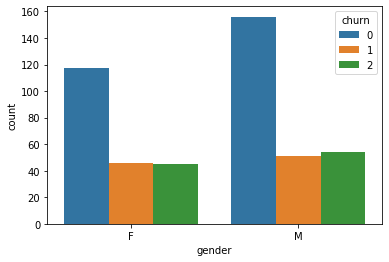

In [20]:
plt.clf()
ax = sns.countplot(x="gender", hue="churn", data=users_gender)
plt.show()

So we can see there is no significant difference between downgrading and cancellation between females and males.

Now let's clear this pandas dataframe.

In [21]:
users_gender.drop(users_gender.index, inplace=True)
users_ch.drop(users_ch.index, inplace=True)
users_dw.drop(users_dw.index, inplace=True)

### How many users were still using the service after churn?

To answer for this question let's collect the users with churned by history of their events with ascending timestamp, to know how everything grew.

In [22]:
churned_users = [df.select("*").where(col("userId") == row).sort('ts').collect() for row in (churned_ids+downgraded_ids)]

In [24]:
staying_ids = df.filter(notInChurn(df.userId)).select("userId").dropDuplicates().collect()
staying_ids = [i.userId for i in staying_ids]

staying_users = [df.select("*").where(col("userId") == row).sort('ts').collect() for row in staying_ids]

Now let's see is some users still were using the service after `Downgrading`. After cancellation the user has removed account and has different id, so it's not trivial task to find such a user.

In [25]:
back_ids = []
for user in churned_users:
    churned_row = False
    r = None
    for row in user:
        if row.page == "Submit Downgrade":
            churned_row = True
            r = row
            continue
        if row.churn == 0 and churned_row == True and row.song != None:
            back_ids.append(row.userId)
            break
            
print("Number of users that downgraded churn: {}, so the downgrading users are {}% of churned users.".format(len(back_ids), (len(back_ids)/len(churned_users))*100))

Number of users that downgraded churn: 118, so the downgrading users are 60.204081632653065% of churned users.


### How different pages relates to churn?

Let's gather the following events and check how they looks like for churn and not churn users. Let's calculate number of interactions with the all of the available pages.

When creating dataset if the churned user is churn by downgrading we need to take only the data until the downgrade, as after downgrade he may behave different from users that are on free model, but never go to premium and then downgraded.

In [26]:
pages = df.select("page").dropDuplicates().collect()
pages = [x.page for x in pages]
pages

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [27]:
def takeUserDowngradeTimestamp(churned_user_id):
    timestamp = df.select('ts').where((df.userId == churned_user_id) & (df.page == "Submit Downgrade")).dropDuplicates().collect()
    if len(timestamp) == 0:
        return 0
    return timestamp[0].ts

In [28]:
def createUserPandasDataset(user_ids, churnValue):
    dataframe = pd.DataFrame(data={'userId': user_ids, 'churn': [churnValue] * len(user_ids)})
    gender = []
    page_lists = []
    for page in pages:
        page_lists.append([])
    
    for user_id in user_ids:
        gender.append(df.select('gender').where(df.userId == user_id).dropDuplicates().collect()[0].gender)
        i = 0
        if (churnValue == 1 or churnValue == 2):
            ts = takeUserDowngradeTimestamp(user_id)
            if ts != 0:
                for page in pages:
                    page_lists[i].append(df.select('page').where((df.userId == user_id) & (df.page == page) & (df.ts < ts)).count())
                    i += 1
                continue

        for page in pages:
            page_lists[i].append(df.select('page').where((df.userId == user_id) & (df.page == page)).count())
            i += 1
    j = 0
    dataframe['Gender'] = gender
    for page in pages:
        dataframe[page] = page_lists[j]
        j += 1
    return dataframe

In [29]:
churned_df = createUserPandasDataset(churned_ids, 2)
downgraded_df = createUserPandasDataset(downgraded_ids, 1)
staying_df = createUserPandasDataset(staying_ids, 0)

In [30]:
users_df = pd.concat([churned_df, staying_df, downgraded_df])
churned_df.drop(churned_df.index, inplace=True)
downgraded_df.drop(downgraded_df.index, inplace=True)
staying_df.drop(staying_df.index, inplace=True)

In [31]:
users_df.head()

,userId,churn,Gender,Cancel,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,...,Login,Register,Add to Playlist,Add Friend,NextSong,Thumbs Up,Help,Upgrade,Error,Submit Upgrade
0,296,2,F,1,0,0,7,1,9,3,...,0,0,3,2,112,8,2,1,0,1
1,100010,2,F,1,0,3,3,0,22,1,...,0,0,1,3,96,4,0,2,0,0
2,200002,2,M,1,0,5,23,3,11,11,...,0,0,6,2,310,15,1,2,0,1
3,51,2,M,1,0,1,17,4,1,6,...,0,0,8,3,266,16,0,0,2,0
4,124,2,F,1,0,15,70,21,1,17,...,0,0,45,26,1826,102,10,0,0,0


In [32]:
users_df.to_pickle("data/users_df.pkl")

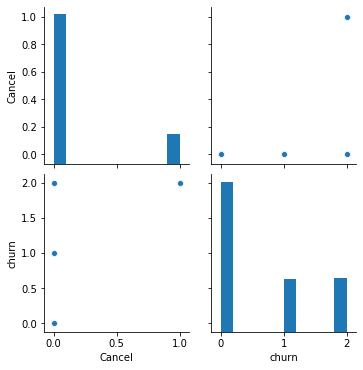

****************************************


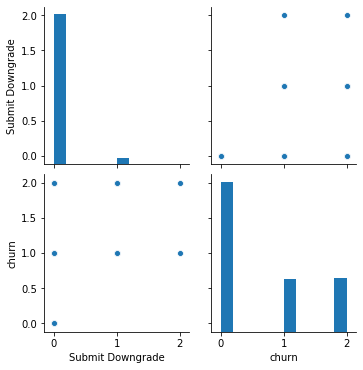

****************************************


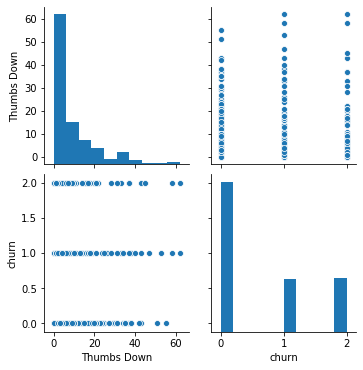

****************************************


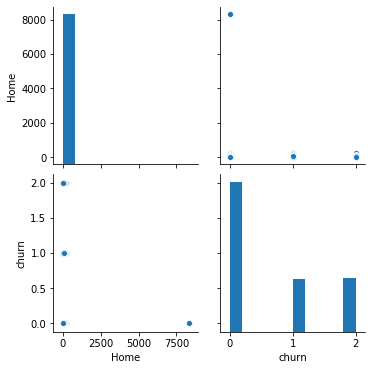

****************************************


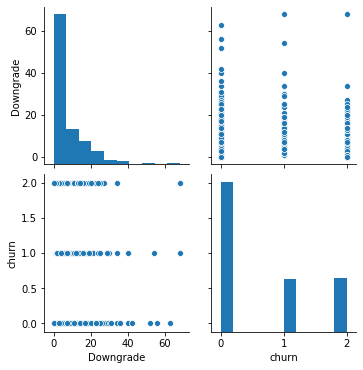

****************************************


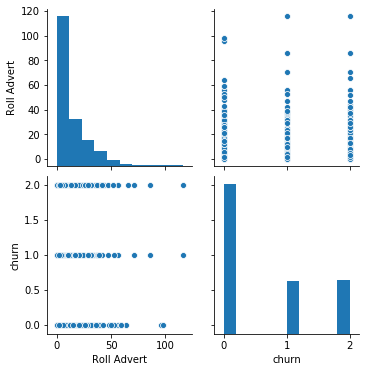

****************************************


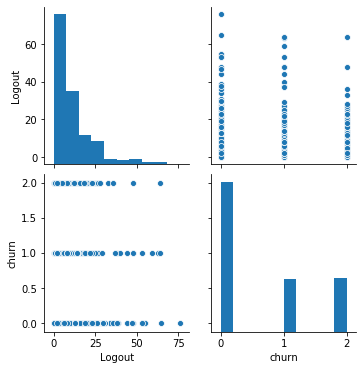

****************************************


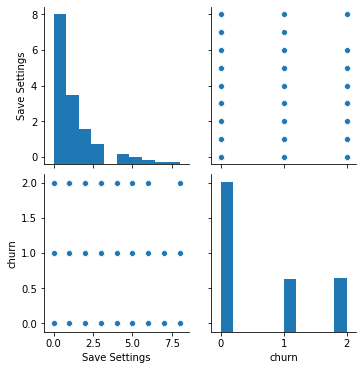

****************************************


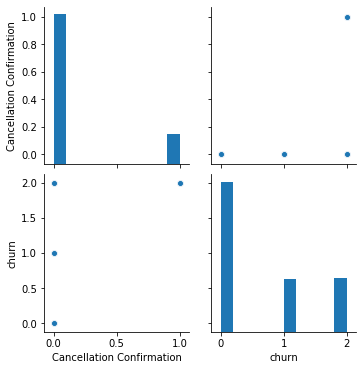

****************************************


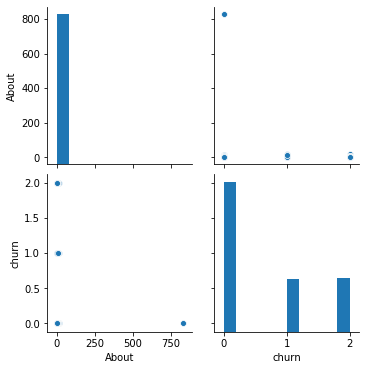

****************************************


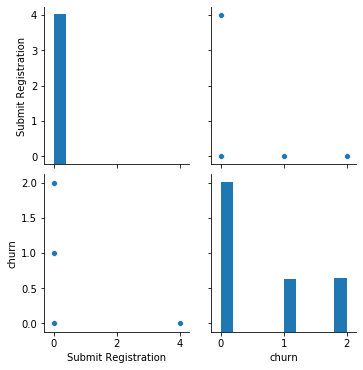

****************************************


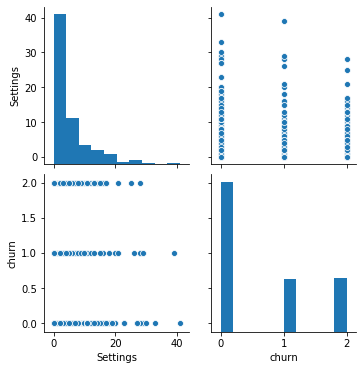

****************************************


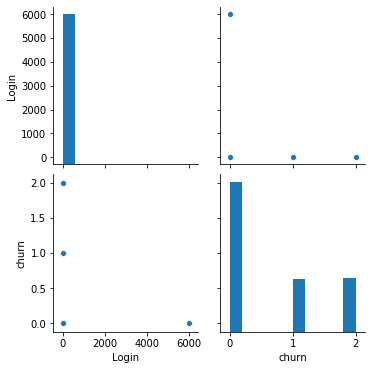

****************************************


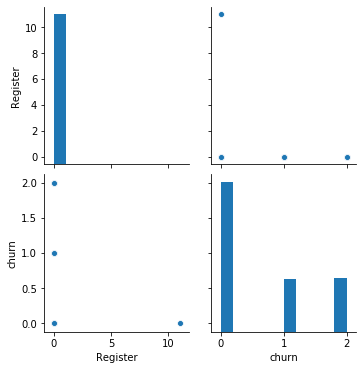

****************************************


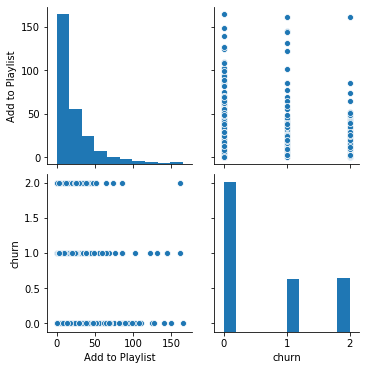

****************************************


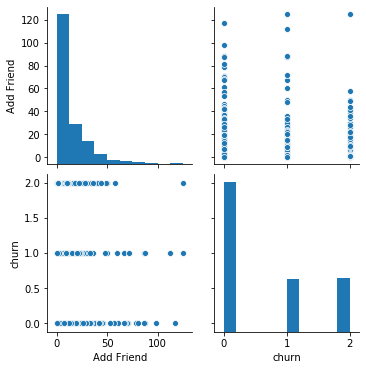

****************************************


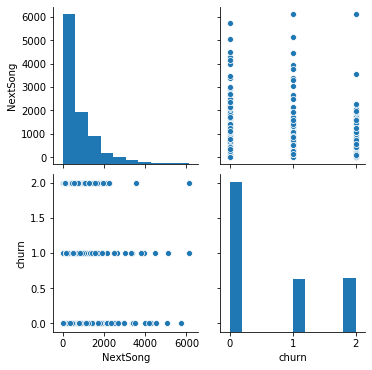

****************************************


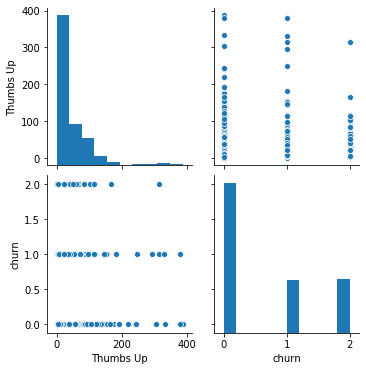

****************************************


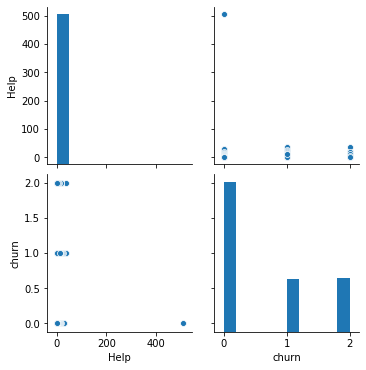

****************************************


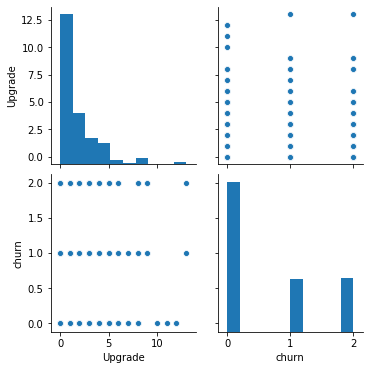

****************************************


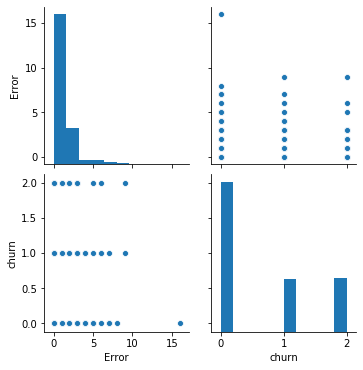

****************************************


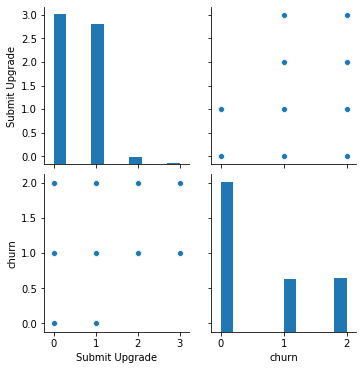

****************************************


In [33]:
for page in pages:
    sns.pairplot(users_df, vars=[page,"churn"])
    plt.show()
    print("****************************************")

### Which features may be important?

Based on diagram presenting gender distribution over churn, I think that gender is not really a matter when it comes to churn for this dataset.

Based on the pair diagrams we can tell that the following pages can help with distinguish the churn and staying users:

* Thumbs Up
* Thumbs Down
* Save Settings
* Add to Playlist
* NextSong
* Add Friend
* Downgrade
* Settings
* Error
* Submit Upgrade

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Calculated number of usages per used pages

For convinience - to avoid doing the same code in Spark like we did for Pandas, let's re-use the pandas dataframe with number of accesses to relevant pages from previous section. 

Columns taken to dataframe are chosen based on observations of pair diagrams done in previous section. This dataframe structure will be used for classifier based on machine learning models.

In [34]:
columns = ['userId','churn','Thumbs Up', 'Thumbs Down', 'Save Settings','Add to Playlist', 'NextSong', 'Add Friend', 'Downgrade', 'Settings', 'Error', 'Submit Upgrade']

users_df = pd.read_pickle("data/users_df.pkl")

In [35]:
df_usages = spark.createDataFrame(users_df[columns])
df_usages = df_usages.orderBy(rand())
df_usages.show(5)


+------+-----+---------+-----------+-------------+---------------+--------+----------+---------+--------+-----+--------------+
|userId|churn|Thumbs Up|Thumbs Down|Save Settings|Add to Playlist|NextSong|Add Friend|Downgrade|Settings|Error|Submit Upgrade|
+------+-----+---------+-----------+-------------+---------------+--------+----------+---------+--------+-----+--------------+
|   101|    0|      305|         55|            3|            165|    5745|       117|       56|      41|    6|             1|
|   167|    2|       10|          4|            0|              8|     199|         0|        0|       1|    0|             0|
|   148|    0|       10|          4|            0|             13|     307|         3|        0|       0|    1|             0|
|100029|    1|        3|          1|            0|              1|      84|         0|        2|       0|    0|             1|
|   132|    2|        4|          1|            0|              4|     113|         4|        2|       0|    0|

Now let's set `VectorAssembler` to gather data from columns to `features` column and `StandardScaler` to scale these features to avoid calculations, to stardardize the numbers.

In [37]:
vectorAssembler = VectorAssembler(inputCols=[df_usages.schema.names[2:]], outputCol="features")
standardScaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures')

TypeError: Invalid param value given for param "inputCols". Could not convert [['Thumbs Up', 'Thumbs Down', 'Save Settings', 'Add to Playlist', 'NextSong', 'Add Friend', 'Downgrade', 'Settings', 'Error', 'Submit Upgrade']] to list of strings

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

First let's split the dataset with 80% elements in training set and 20% in test set.

In [36]:
trainingData, testData = df_usages.randomSplit([0.8, 0.2], seed=42)

### First Model - Random Forest Classifier

In first pipeline we'll use the Random Forst Classifier to determine whether the user will churn or not.

In [ ]:
rf = RandomForestClassifier(labelCol="churn", featuresCol="scaledFeatures")

In [ ]:
pipeline = Pipeline(stages=[vectorAssembler, standardScaler, rf])

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, range(5, 65, 6)) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="churn"),
                          numFolds=5)

In [ ]:
model = crossval.fit(trainingData)

In [ ]:
results = model.transform(testData)
print("Random Forest Classifier Accuracy: {}%".format((results.filter(results.churn == results.prediction).count()/results.count())*100))

### Second Model - Logistic Regression

Second model will use Logistic Regression to predict churn users.

In [ ]:
lr = LogisticRegression(labelCol="churn", featuresCol="scaledFeatures")

In [ ]:
pipeline = Pipeline(stages=[vectorAssembler, standardScaler, lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, range(2,22,2)) \
    .addGrid(lr.regParam, [0.1, 0.3, 0.5, 0.7, 0.9]) \
    .addGrid(lr.elasticNetParam, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="churn"),
                          numFolds=5)

In [ ]:
model = crossval.fit(trainingData)

In [ ]:
results = model.transform(testData)
print("Logistic Regression Accuracy: {}%".format((results.filter(results.churn == results.prediction).count()/results.count())*100))

### Third Model - Multilayer Perceptron Classifier

Second model will use Multilayer Perceptrion to predict churn users.

In [ ]:
mlp = MultilayerPerceptronClassifier(featuresCol='scaledFeatures', labelCol='churn', seed=42)

In [ ]:
input_len = len(df_usages.schema.names[2:])

pipeline = Pipeline(stages=[vectorAssembler, standardScaler, mlp])

paramGrid = ParamGridBuilder() \
    .addGrid(mlp.maxIter, [100,150,200,250]) \
    .addGrid(mlp.blockSize, [8, 16, 32, 64, 128]) \
    .addGrid(mlp.layers, [[input_len,10,10,10,3],[input_len,20,20,20,3],[input_len,30,30,30,3],[input_len,40,40,40,3],[input_len,50,50,50,3]]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="churn"),
                          numFolds=5)

In [ ]:
model = crossval.fit(trainingData)

In [ ]:
results = model.transform(testData)
print("Multilayer Perceptron Accuracy: {}%".format((results.filter(results.churn == results.prediction).count()/results.count())*100))

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.